In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px

from classBanditsDynamic import Bandits

In [2]:
from classBanditsDynamic import Bandits

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

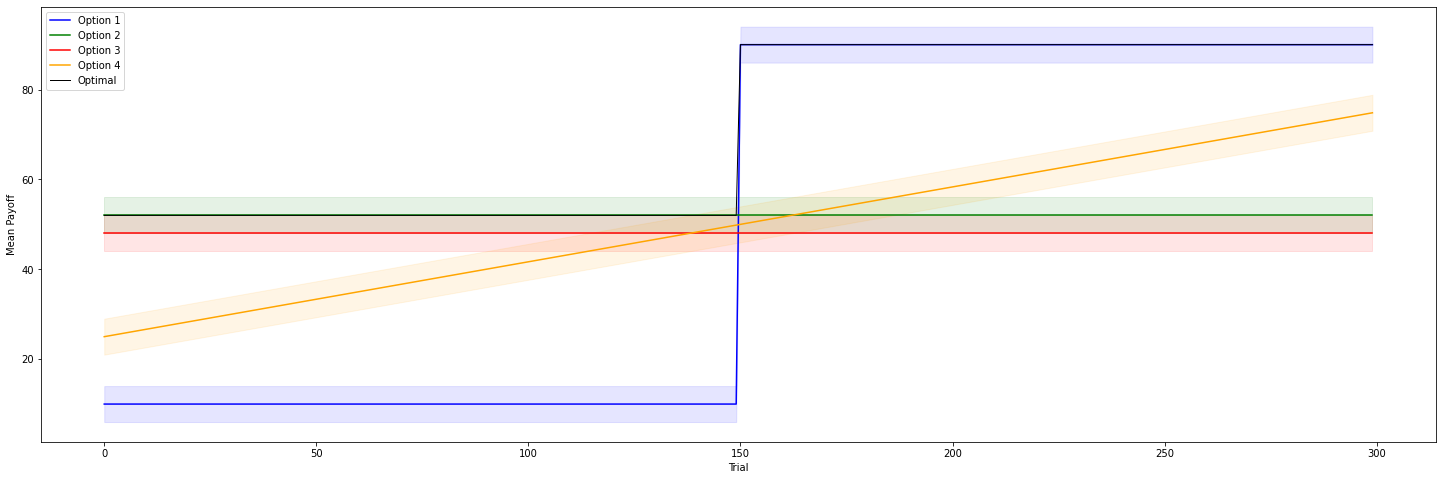

In [6]:
''' Initialising simulation class from loaded payoff function, calculating optimal solution, and printing loaded payoff function'''
total_time = 300
simu = Bandits(total_time)
payoffs = np.genfromtxt('payoffs/payoffs_step2.csv',delimiter=',')
[_, optimal_scores,_] = simu.findRegret(payoffs,0)
simu.options = len(payoffs)

# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.legend()
plt.show()

In [215]:
''' Payoff generation and saving code '''
payoffs = np.zeros([4,300])
for i in range(300):
    payoffs[1,i] = 52
    payoffs[0,i] = (10 if i < 150 else 90)
    payoffs[2,i] = 48
    payoffs[3,i] = i/300 * 50 + 25

# payoffs = simu.genMeans(15)
# np.savetxt('payoffs_step2.csv',payoffs,delimiter=',')

In [8]:
''' Simulating trials with the loaded payoff function for the strategies: pure exploitation, discounted softmax, discounted UCB1.
    The optimal sampling proportion from each of the options is also shown, and compared to with the proportions sampled by the softmax and UCB algorithms.'''

exploit_reward = simu.exploit(payoffs,1000)
[exploit_regret, _, optimal_choices] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploit Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))
unique, counts = np.unique(optimal_choices, return_counts = True)
print('Proportions sampled (optimal):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARMAS: 1, 0.995
# PAYOFF 4 PARAMS: 3.55, 0.99
# STEP 1 PARAMS: 1.6, 0.99
softmax_reward, softmax_choices,softmax_history = simu.softmax(payoffs,3,0.92,100)
[softmax_regret, _, _] = simu.findRegret(payoffs,softmax_reward)
print('Pure Softmax Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))
unique, counts = np.unique(softmax_choices, return_counts = True)
print('Proportions sampled (softmax):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARAMS: 1, 0.995
# PAYOFF 4 PARAMS: 4.6, 0.99
# STEP 1 PARAMS: 2.3, 0.99
dUCB_reward, dUCB_choices = simu.dUCB1(payoffs,3,0.92,1000)
[dUCB_regret, _, _] = simu.findRegret(payoffs,dUCB_reward)
print('Softmax + IB Mean Regret: %s'% np.mean(dUCB_regret),', Std: %s'% np.std(dUCB_regret))
unique, counts = np.unique(dUCB_choices, return_counts = True)
print('Proportions sampled (softmax + IB):  ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

Pure exploit Mean Regret: 0.28396330384215374 , Std: 0.023570999388434252
Proportions sampled (optimal):    blue: 0.5, green: 0.5

Pure Softmax Mean Regret: 0.1327298328986072 , Std: 0.01587985456170483
Proportions sampled (softmax):    blue: 0.32, green: 0.23, red: 0.22, orange: 0.23

Softmax + IB Mean Regret: 0.11360687337391558 , Std: 0.012831810431715768
Proportions sampled (softmax + IB):   blue: 0.34, green: 0.2, red: 0.19, orange: 0.27



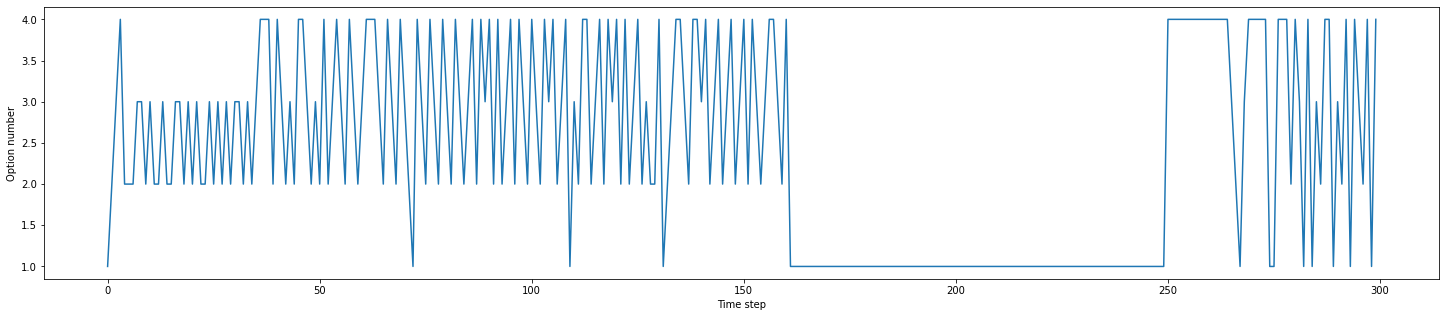

In [247]:
''' Plotting the choice history for one trial under the specific algorithm used. '''
fig,ax = plt.subplots(figsize=(25,5))
trial = 3
plt.plot(dUCB_choices[trial,:]+1) # getting into range 1,2,3,4
plt.xlabel('Time step')
plt.ylabel('Option number')
plt.show()

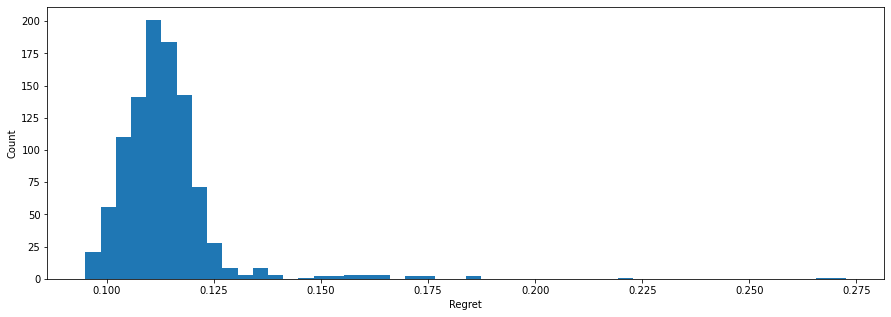

[0.11360687337391558, 0.11235687176665471]


In [9]:
''' Plotting the regret distribution over all the trials taken under a specific algorithm. '''
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(dUCB_regret,50) 
plt.xlabel('Regret')
plt.ylabel('Count')
plt.show()
print([np.mean(dUCB_regret),np.median(dUCB_regret)])

In [206]:
''' Computing optimal parameters for each algorithm by looping over ranges'''
regret_list = np.zeros(10)
params = np.linspace(0.1,3,10)
for i in range(10):
    reward, choices,_ = simu.softmax(payoffs,params[i],0.98,100)
    [regret, _,_] = simu.findRegret(payoffs,reward)
    regret_list[i] = np.mean(regret)
optimal_temp = params[np.argmin(regret_list)]
print('Optimal temp: ', optimal_temp)
print('Softmax Mean Regret: %s'% regret_list[np.argmin(regret_list)]) # 3.2632: 0.1223


C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: overflow encountered in exp
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: invalid value encountered in true_divide
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])


Optimal temp:  3.0
Softmax Mean Regret: 0.23489829321547429
